# Custom map simulations

In this tutorial we will build a simulation from scratch.

We start by defining a `Band` that will determine our array's sensitivity to different spectra. We then generate an array by specifying a field of view, which will be populated by evenly-spaced beams of the given band.

In [1]:
import maria
from maria.instrument import Band

f090 = Band(center=90, # in GHz
            width=20,
            sensitivity=3e-5) # in K sqrt(s)

f150 = Band(center=150,
            width=30,
            sensitivity=5e-5)

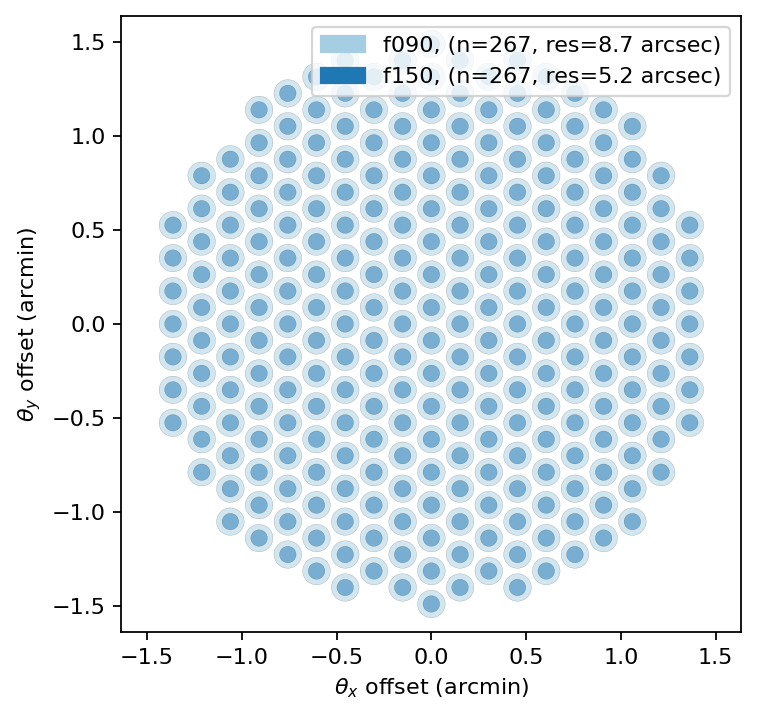

In [2]:
array = {"field_of_view": 0.05, "bands": [f090, f150]}

instrument = maria.get_instrument(array=array, primary_size=100)

instrument.plot()

As something to observe, we can download a map and construct a `map`. We also define a plan to do a daisy scan centered on the center of the map.

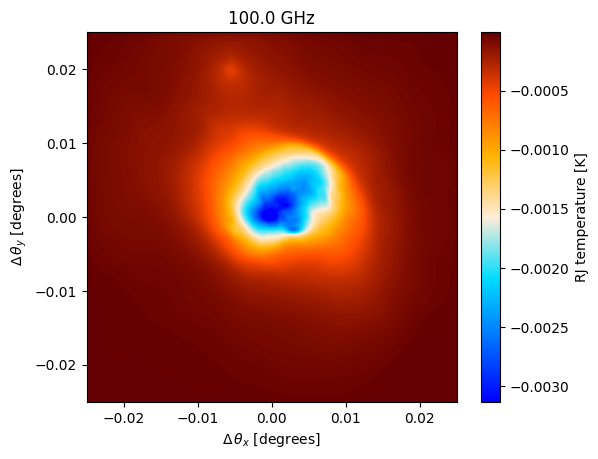

In [3]:
from maria.io import fetch

map_filename = fetch("maps/cluster.fits")

input_map = maria.map.from_fits(filename=map_filename, 
                                width=0.05, 
                                center=(150, 10),
                                units = 'Jy/pixel')

# input_map.data *= 1e2

plan = maria.get_plan(scan_pattern="daisy",
                      scan_options={"radius": 0.025, "speed": 0.005}, # in degrees
                      duration=600, # in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10),
                      frame="ra_dec")

input_map.plot()

In [4]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                      )

Initialized base in 3138 ms.


Initializing atmospheric layers: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


In [5]:
tod = sim.run()

Generating noise: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]
Generating atmosphere: 4it [00:04,  1.05s/it]
Computing atm. emission (f090):   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=1e-1, 
                   height=1e-1,
                   resolution=4e-4,
                   tod_postprocessing={
                        "remove_modes": {"n": 1},
                        "highpass": {"f": 0.8},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)

output_map = mapper.run()

Running mapper (f150): 100%|██████████| 1/1 [00:13<00:00, 13.53s/it]


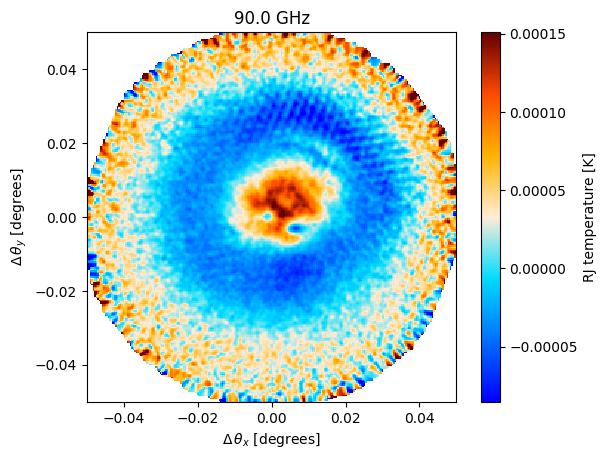

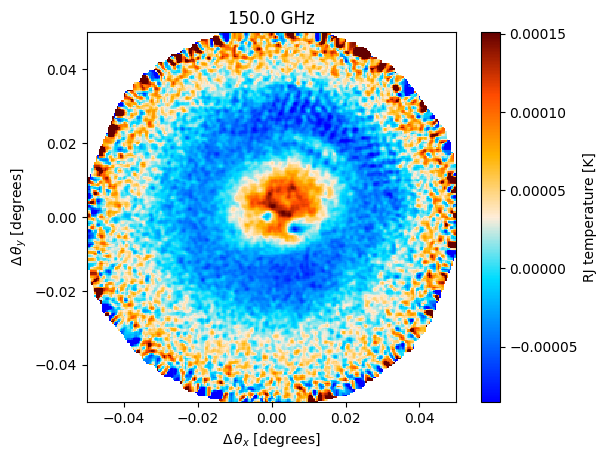

In [ ]:
output_map.plot()

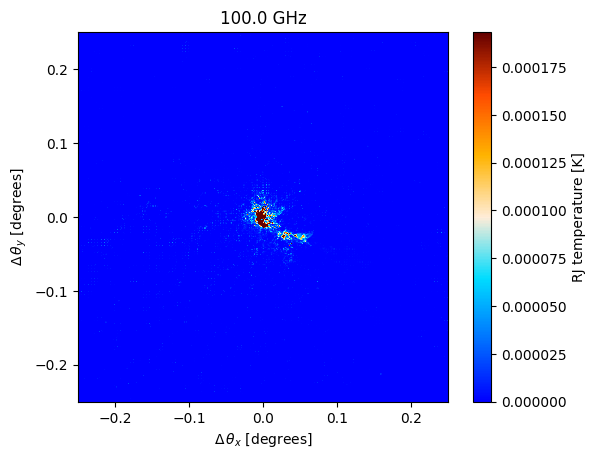

In [ ]:
map_filename = fetch("maps/galaxy.fits")

galaxy_map = maria.map.from_fits(filename=map_filename, 
                          width=0.5, 
                          center=(150, 10))

plan = maria.get_plan(scan_pattern="daisy",
                      scan_options={"radius": 0.05, "speed": 0.005}, # in degrees
                      duration=600, # in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10),
                      frame="ra_dec")

galaxy_map.plot()

In [ ]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=galaxy_map)

Initialized base in 2280 ms.


In [ ]:
tod = sim.run()

Sampling map (f150): 100%|██████████| 2/2 [00:15<00:00,  7.83s/it]


In [ ]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=5e-2, 
                   height=5e-2,
                   resolution=2e-4,
                   tod_postprocessing={
                        "remove_modes": {"n": 1},
                        "highpass": {"f": 0.8},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)

output_map = mapper.run()

Running mapper (f150): 100%|██████████| 1/1 [00:14<00:00, 14.55s/it]


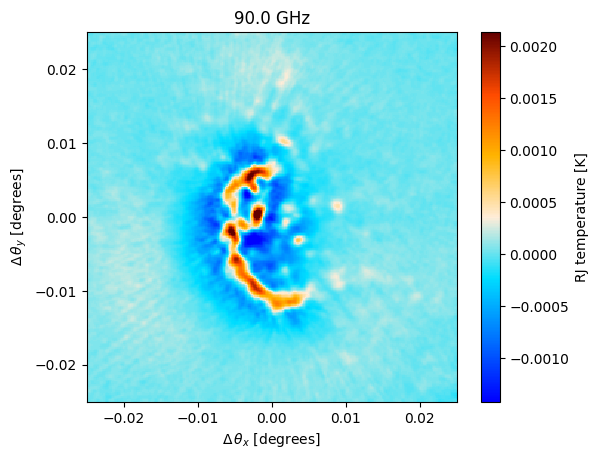

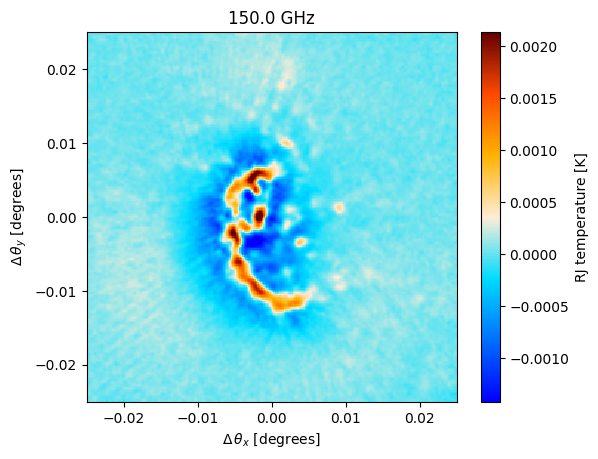

In [ ]:
output_map.plot()